In [17]:
import numpy as np
import json
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import pt_predictions

In [18]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')


# Read simulation outputs

In [19]:
from streaming.models.inputs import SimulationMeasurements

pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"
simulation = SimulationMeasurements(pdf_filename, tpcf_filename)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py-2.9.0-py3.6-linux-x86_64.egg/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Compute perturbation theory predictions

In [20]:
cosmo_dict = json.load( open( "../data/cosmology.json" ) )
linear_growth = cosmo_dict['growth']

In [21]:
data_path = '/cosma/home/dp004/dc-cues1/CLPT_GSRSD/data/'
linear_pk_file = 'linear_pow.txt'

In [22]:
pt = pt_predictions.PerturbationTheory(
                        data_path,
                        linear_pk_file,
                        linear_growth,
                        simulation.tpcf.mean,
                        )

Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.31959789506378544, b2 = -0.14176026225712607)
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.30941045525994015, b2 = -0.13100785450375235, bs = -53.29491534487465)
Found best fit alpha_eft parameter: alpha_eft = 1.0139678422605642


In [23]:
pt.eft.r.min()

11.0

# Check EFT parameters set to 0 gives same results

In [24]:
pt.eft.b1 = pt.clpt.b1
pt.eft.b2  = pt.clpt.b2
pt.eft.bs = 0.
pt.eft.alpha_eft = 0.
pt.eft.alpha_eft_v = 0.

pt.eft.tpcf = pt.eft.get_tpcf(pt.eft.r,
                              pt.eft.b1,
                              pt.eft.b2,
                              pt.eft.bs,
                              pt.eft.alpha_eft)

pt.eft.v12 = pt.eft.get_v12(pt.eft.b1, 
                            pt.eft.b2,
                            pt.eft.bs,                                                              
                            pt.eft.alpha_eft,
                            pt.eft.alpha_eft_v)
pt.eft.s12_par, pt.eft.s12_perp = pt.eft.get_s12(pt.eft.b1,
                                                pt.eft.b2,
                                                pt.eft.bs,                               
                                                pt.eft.alpha_eft,
                                                pt.eft.alpha_eft_v)

Text(0,0.5,'Ratio')

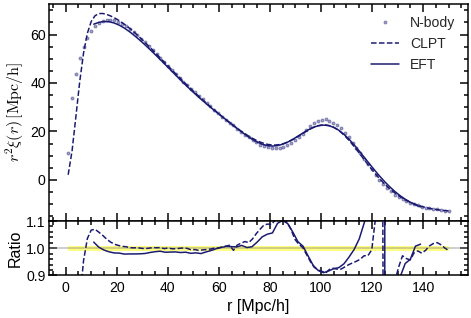

In [25]:

# --------------- Tpcf --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].plot(pt.clpt.r, 
            pt.clpt.r**2*simulation.tpcf.mean(pt.clpt.r),
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'N-body', alpha = 0.4)

axes[0].plot(pt.clpt.r, 
             pt.clpt.r**2*pt.clpt.tpcf,
            color = 'midnightblue',label = 'CLPT',
            linestyle = 'dashed')

axes[0].plot(pt.eft.r, 
             pt.eft.r**2*pt.eft.tpcf,
            color = 'midnightblue', label = 'EFT')

axes[0].set_ylabel(r'$r^2\xi(r) \, \mathrm{[Mpc/h]}$')
axes[0].legend()
axes[1].fill_between(pt.clpt.r,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(pt.eft.r, pt.eft.tpcf / simulation.tpcf.mean(pt.eft.r), 
         color = 'midnightblue')

axes[1].plot(pt.clpt.r, pt.clpt.tpcf / simulation.tpcf.mean(pt.clpt.r), 
         color = 'midnightblue', linestyle = 'dashed')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r'r [Mpc/h]')
axes[1].set_ylabel(r'Ratio')

Text(0,0.5,'Ratio')

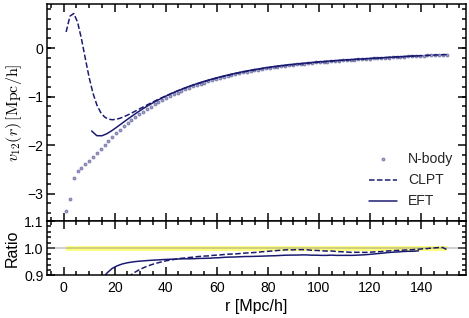

In [26]:
# --------------- v12 --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].plot(pt.clpt.r, 
            simulation.m_10.mean(pt.clpt.r),
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'N-body', alpha = 0.4)
axes[0].plot(pt.clpt.r, 
            pt.clpt.v12,
            color = 'midnightblue',label = 'CLPT',
            linestyle = 'dashed')

axes[0].plot(pt.eft.r, 
             pt.eft.v12,
            color = 'midnightblue', label = 'EFT')

axes[0].set_ylabel(r'$v_{12}(r) \, \mathrm{[Mpc/h]}$')
axes[0].legend()
axes[1].fill_between(pt.clpt.r,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(pt.eft.r, pt.eft.v12 / simulation.m_10.mean(pt.eft.r), 
         color = 'midnightblue')

axes[1].plot(pt.clpt.r, pt.clpt.v12 / simulation.m_10.mean(pt.clpt.r), 
         color = 'midnightblue', linestyle = 'dashed')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r'r [Mpc/h]')
axes[1].set_ylabel(r'Ratio')

In [27]:
interp_clpt = interp1d(pt.clpt.r,pt.clpt.s12_par)
clpt_sfog = simulation.c_20.mean(100.) - interp_clpt(100.)
print(clpt_sfog)

-17.443056850995678


Text(0,0.5,'Ratio')

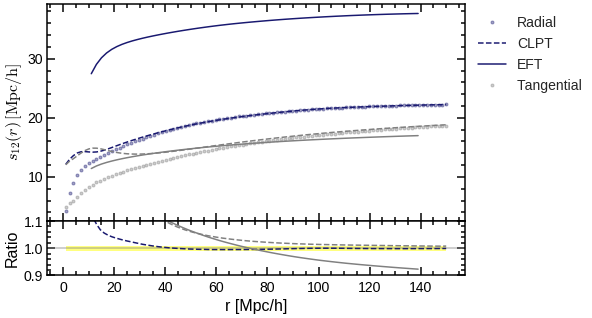

In [28]:
# --------------- v12 --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].plot(pt.clpt.r, 
            simulation.c_20.mean(pt.clpt.r),
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(pt.clpt.r, 
            pt.clpt.s12_par + clpt_sfog,
            color = 'midnightblue',label = 'CLPT',
            linestyle = 'dashed')

axes[0].plot(pt.eft.r, 
             pt.eft.s12_par,
            color = 'midnightblue', label = 'EFT')

axes[0].plot(pt.clpt.r, 
            simulation.c_02.mean(pt.clpt.r),
            marker = 'o', linestyle = '',
            color = 'gray', label = 'Tangential', alpha = 0.4)
axes[0].plot(pt.clpt.r, 
            pt.clpt.s12_perp + clpt_sfog,
            color = 'gray',
            linestyle = 'dashed')

axes[0].plot(pt.eft.r, 
             pt.eft.s12_perp,
            color = 'gray')

axes[0].set_ylabel(r'$s_{12}(r) \, \mathrm{[Mpc/h]}$')
axes[0].legend(bbox_to_anchor = (1,1))
axes[1].fill_between(pt.clpt.r,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(pt.eft.r, pt.eft.s12_par / simulation.c_20.mean(pt.eft.r), 
         color = 'midnightblue')

axes[1].plot(pt.clpt.r, (pt.clpt.s12_par +clpt_sfog) / simulation.c_20.mean(pt.clpt.r), 
         color = 'midnightblue', linestyle = 'dashed')


axes[1].plot(pt.eft.r, pt.eft.s12_perp / simulation.c_02.mean(pt.eft.r), 
         color = 'gray')

axes[1].plot(pt.clpt.r, (pt.clpt.s12_perp  +clpt_sfog) / simulation.c_02.mean(pt.clpt.r), 
         color = 'gray', linestyle = 'dashed')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r'r [Mpc/h]')
axes[1].set_ylabel(r'Ratio')

# Test fitting range to find b1 and b2

In [29]:
r, s2monopole, s2quadrupole = pt.eft.get_multipoles(
                                                pt.eft.b1, 
                                                pt.eft.b2, 
                                                pt.eft.bs, 
                                                pt.eft.alpha_eft, 
                                                pt.eft.alpha_eft_v, 
                                                0., 
                                                )

In [30]:
minimum_r = np.arange(10, 60, 2)
varying_r = []
for rmin in minimum_r:
    pt = pt_predictions.PerturbationTheory(
                        data_path,
                        linear_pk_file,
                        linear_growth,
                        simulation.tpcf.mean,
                        r_min = rmin
                        )
    
    varying_r.append(pt)

Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.2833912754904918, b2 = -0.5038693672093447)
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.3312150327091475, b2 = -0.583196551468073, bs = -26.369695252933678)
Found best fit alpha_eft parameter: alpha_eft = 0.21333281783650682
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.2774835416745113, b2 = -0.6173147990055785)
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.3312334001284889, b2 = -0.5838071351262307, bs = -26.468630421545328)
Found best fit alpha_eft parameter: alpha_eft = 0.21242005087737534
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.28660543949058337, b2 = -0.5168980158157774)
Fitting free parameters to the simulation tpcf...
Found best fit bias parameters: (b1 = 0.33339498350451274, b2 = -0.6488701981105656, bs = -3

Text(0,0.5,'$b_1$')

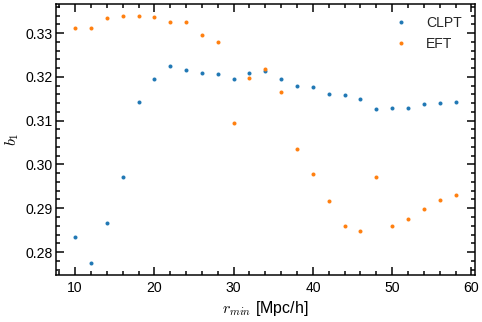

In [31]:
plt.plot(minimum_r, [pt.clpt.b1  for pt in varying_r], 
        linestyle = '', marker = 'o', label = 'CLPT')

plt.plot(minimum_r, [pt.eft.b1  for pt in varying_r], 
        linestyle = '', marker = 'o', label = 'EFT')
plt.legend()
plt.xlabel(r'$r_{min}$ [Mpc/h]')
plt.ylabel(r'$b_1$')

Text(0,0.5,'$b_2$')

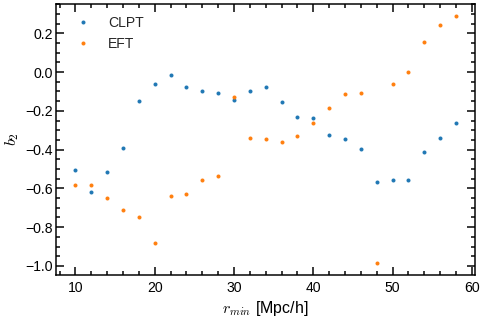

In [32]:
plt.plot(minimum_r, [pt.clpt.b2  for pt in varying_r], 
        linestyle = '', marker = 'o', label = 'CLPT')

plt.plot(minimum_r, [pt.eft.b2  for pt in varying_r], 
        linestyle = '', marker = 'o', label = 'EFT')
plt.legend()
plt.xlabel(r'$r_{min}$ [Mpc/h]')
plt.ylabel(r'$b_2$')